In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

#  Building Unet model by dividing encoder and decoder into blocks

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Load Data

In [ ]:
train_img_dir = "/content/drive/MyDrive/Wheat head Segmentation Project/SAM/dataset_SAM/All images/train"
train_mask_dir = "/content/drive/MyDrive/Wheat head Segmentation Project/SAM/dataset_SAM/All images/convert json to mask/train mask"

img_list = os.listdir(train_img_dir)
img_list.sort()
msk_list = os.listdir(train_mask_dir)
msk_list.sort()
num_images = len(os.listdir(train_img_dir))
print("Total number of training images are: ", num_images)

Total number of training images are:  2703


# Print a random image with its mask image

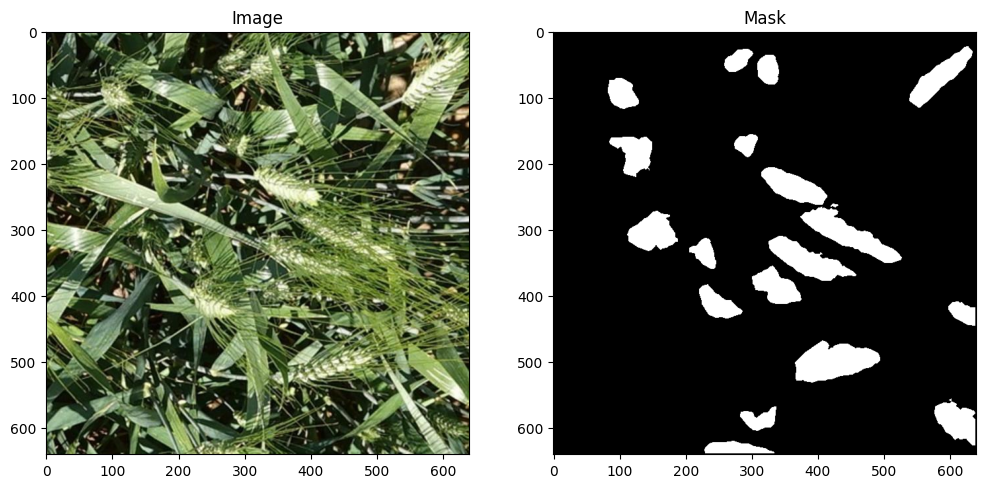

In [ ]:
img_num = random.randint(0, num_images - 1)

img_for_plot = cv2.imread(os.path.join(train_img_dir, img_list[img_num]))
mask_for_plot = cv2.imread(os.path.join(train_mask_dir, msk_list[img_num]))
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)
mask_for_plot = cv2.cvtColor(mask_for_plot, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot)
plt.title('Mask')
plt.show()

In [ ]:
print("Unique values in the mask are: ", np.unique(mask_for_plot))


Unique values in the mask are:  [  0 255]


# Mask encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
h, w, _ = mask_for_plot.shape
mask_for_plot_reshaped = mask_for_plot.reshape(-1,1)
mask_for_plot_reshaped_encoded = labelencoder.fit_transform(mask_for_plot_reshaped)
mask_for_plot_encoded = mask_for_plot_reshaped_encoded.reshape(h, w, -1)
print("Unique values in the mask after endcoding are: ", np.unique(mask_for_plot_encoded))

Unique values in the mask after endcoding are:  [0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def load_data(img_dir, msk_dir, target_size=(128, 128)):
    img_list = sorted(os.listdir(img_dir))
    msk_list = sorted(os.listdir(msk_dir))

    images = []
    masks = []

    for img_filename, msk_filename in zip(img_list, msk_list):
        img_path = os.path.join(img_dir, img_filename)
        msk_path = os.path.join(msk_dir, msk_filename)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

        # Resize images and masks
        img = cv2.resize(img, target_size)
        msk = cv2.resize(msk, target_size)

        images.append(img)
        masks.append(msk)

    images = np.array(images)
    masks = np.array(masks)

    # Normalize images
    images = images / 255.0

    # Encode masks
    label_encoder = LabelEncoder()
    masks_reshaped = masks.reshape(-1, 1)
    masks_encoded = label_encoder.fit_transform(masks_reshaped)
    masks_encoded = masks_encoded.reshape(masks.shape)

    return images, masks_encoded

# Model train

In [ ]:
train_img_dir = "/content/drive/MyDrive/Wheat head Segmentation Project/SAM/dataset_SAM/All images/train"
train_mask_dir = "/content/drive/MyDrive/Wheat head Segmentation Project/SAM/dataset_SAM/All images/convert json to mask/train mask"

from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Wheat head Segmentation Project/UNet/U_Net_v1/3 3/model.h5', monitor='val_loss', save_best_only=True)


images, masks = load_data(train_img_dir, train_mask_dir)

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
input_shape = (128, 128, 1)
n_classes = 1
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_masks, epochs=50, batch_size=8, validation_data=(val_images, val_masks),callbacks=[early_stopping, model_checkpoint])


sigmoid
Epoch 1/50
271/271 [==============================] - 57s 169ms/step - loss: 67.7810 - accuracy: 0.8901 - val_loss: 77.9166 - val_accuracy: 0.8673
Epoch 2/50
271/271 [==============================] - 51s 190ms/step - loss: 65.0526 - accuracy: 0.9278 - val_loss: 71.0245 - val_accuracy: 0.9019
Epoch 3/50
271/271 [==============================] - 50s 184ms/step - loss: 64.1815 - accuracy: 0.9359 - val_loss: 64.6125 - val_accuracy: 0.9272
Epoch 4/50
271/271 [==============================] - 51s 189ms/step - loss: 63.7475 - accuracy: 0.9385 - val_loss: 64.0780 - val_accuracy: 0.9371
Epoch 5/50
271/271 [==============================] - 54s 200ms/step - loss: 63.3022 - accuracy: 0.9419 - val_loss: 63.0957 - val_accuracy: 0.9402
Epoch 6/50
271/271 [==============================] - 46s 170ms/step - loss: 63.0490 - accuracy: 0.9438 - val_loss: 65.3213 - val_accuracy: 0.9241
Epoch 7/50
271/271 [==============================] - 46s 169ms/step - loss: 62.7713 - accuracy: 0.9454 - val_

In [ ]:
model.save('/content/drive/MyDrive//UNet_50epochs.hdf5')

# Model evaluation

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Convert best model from pt to onnx

In [ ]:
!pip install onnx
!pip install tf2onnx
!pip install onnxruntime

In [ ]:
import onnx
import os
import tf2onnx

from tensorflow.keras.models import load_model
loaded_keras_model = load_model('/content/drive/MyDrive/Wheat head Segmentation Project/UNet/U_Net_v1/3 3/model.h5')
onnx_model, _ = tf2onnx.convert.from_keras(loaded_keras_model)
onnx.save(onnx_model, '/content/drive/MyDrive/')

#Inferece using onnx model

In [ ]:
import cv2
import numpy as np
import onnxruntime
import time

model_path = '/content/drive/MyDrive/Wheat segmentation/Onnx Model/ U_Net.onnx'
image_path = '/content/drive/MyDrive/Wheat head Segmentation Project/Data/test img/2fd875eaa.jpg'

img = cv2.imread(image_path)
H, W, _ = img.shape
img_resized = cv2.resize(img, (128, 128))
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

img_input = img_rgb.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)
img_input = img_input[np.newaxis, ...]

expected_input_shape = (1, 128, 128, 1)
img_input = np.resize(img_input, expected_input_shape)

# Measure inference time
start_time = time.time()

ort_session = onnxruntime.InferenceSession(model_path)
outputs = ort_session.run(None, {'input_2': img_input})

inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.4f} seconds")

masks = outputs[0][0] * 255
masks_resized = cv2.resize(masks, (W, H), interpolation=cv2.INTER_LINEAR)

_, binary_mask = cv2.threshold(masks_resized, 128, 255, cv2.THRESH_BINARY)

binary_mask = binary_mask.astype(np.uint8)
contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

combined_mask = np.zeros((H, W), dtype=np.uint8)

polygons = []
bounding_boxes = []

for contour in contours:
    if cv2.contourArea(contour) > 0.5:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon)

        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x + w, y + h))

result_image = img.copy()

red_color = (0, 255, 0)
label_color = (0, 0, 255)
thickness = 2

for box in bounding_boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(result_image, (x1, y1), (x2, y2), red_color, thickness)

    cv2.putText(result_image, 'Wheat', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, label_color, thickness)

light_green_color = (144, 238, 144)

cv2.fillPoly(result_image, polygons, color=light_green_color)

cv2.imwrite('./output.png', result_image)